In [1]:
import json
import os
import sys
import fnmatch


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [85]:
df = pd.read_csv('avg_stats.csv')#pd.read_csv('BBGM_League_7_all_seasons_Average_Stats.csv')
df.shape

(22587, 76)

In [86]:
y = df.iloc[:,-15:]
X = df.iloc[:,11:-17]
y = y[(X['AST%'] >0) & (X['AST%'] < 100)]
X = X[(X['AST%'] >0) & (X['AST%'] < 100)]
X['MP'] = df.MP
X['Hgt'] = df['Hgt']
df.columns


Index(['pid', 'Name', 'Pos', 'DraftPick', 'Age', 'Salary', 'Team', 'Season',
       'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'TOV', 'STL', 'Blk', 'BA', 'PF',
       'PTS', 'AtRimFG', 'AtRimFGA', 'AtRimFGP', 'LowPostFG', 'LowPostFGA',
       'LowPostFGP', 'MidRangeFG', 'MidRangeFGA', 'MidRangeFGP', 'PER', 'ORtg',
       'DRtg', 'OWS', 'DWS', 'WS', 'WS/48', 'EWA', 'TS%', '3PAr', 'FTr',
       'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', '+/-',
       'Ovr', 'Pot', 'Hgt', 'Str', 'Spd', 'Jmp', 'End', 'Ins', 'Dnk', 'FT.1',
       '2Pt', '3Pt', 'oIQ', 'dIQ', 'Drb', 'Pss', 'Reb'],
      dtype='object')

In [87]:
stat_list = ['FG','FGA','3P',"3PA",'FT','FTA',\
             'ORB','DRB','TRB','AST','TOV','STL',"Blk",\
             'PF','PTS']
for name in stat_list:
    den = np.maximum(1,df.MP)
    #if name in ['OWS','DWS']:
    #    den = den*df['G']
    #X[name] = df[name]
    X[name + 'p36'] = 36* df[name]/den
    X[name + 'p100'] = X[name + 'p36']*4/3

if False:
    X['3PtP'] = (2/(1+np.exp(-X['3PAp100']))-1)*X['3P%']/100
    X['Creation'] = X['ASTp100']*0.1843+(X['PTSp100']+X['TOVp100'])*0.0969-2.3021*X['3PtP']+0.0582*(X['ASTp100']*(X['PTSp100']+X['TOVp100'])*X['3PtP'] )-1.1942
    X['Load'] = (X['ASTp100']-(0.38*X['Creation'])*0.75)+X['FGAp100']+X['FTAp100']*0.44+X['Creation']+X['TOVp100']
    X['cTOV'] = X['TOVp100']/X['Load']
    X['DPM'] = X['Blkp100']*0.802+X['DRBp100']*0.42-4.7-0.07551*X['PFp100']+1.597019*X['STLp100']-0.26385*X['TOVp100']
    X['OPM'] = -8.57647+0.6111*X['PTSp100']-0.33918*(0.44*X['FTAp100']+X['FGAp100'])+0.440814*X['FTAp100']+0.379745*X['3PAp100']+0.634044*X['ASTp100']+0.77827*X['ORBp100']-1.08855*X['TOVp100']+0.26262*X['STLp100']
    X['BPM'] = X['OPM'] + X['DPM']
    X['Age'] = df['Age']

#X['PassP'] = ((X['ASTp100']-(0.38*X['Creation']))*0.752+ X['Creation'] + X['TOVp100']) ** 0.67
#'OPM','DPM','cTOV','Load'#stat_list[:-2]+
X = X[[_ for _ in X.columns if '%A' in _ or _[-1]=='r' or "+/-" in _ or 'p36' in _ or _ in (['OPM','BPM','DPM','Creation','cTOV','Load','Age','MP'])]]
if True:
    X = X[[_ for _ in X.columns if not '3P' in _]]
    X = X[[_ for _ in X.columns if not 'Rim' in _]]
    X = X[[_ for _ in X.columns if not 'Post' in _]]
    X = X[[_ for _ in X.columns if not 'Mid' in _]]
    X = X[[_ for _ in X.columns if not 'TOV' in _]]
    X = X[[_ for _ in X.columns if not 'Blk' in _]]
    X = X[[_ for _ in X.columns if not 'ORB' in _]]
    X = X[[_ for _ in X.columns if not 'DRB' in _]]
    X = X[[_ for _ in X.columns if not 'STL' in _]]
    X = X[[_ for _ in X.columns if not 'DPM' in _]]
    X = X[[_ for _ in X.columns if not 'OPM' in _]]
    X = X[[_ for _ in X.columns if not 'BPM' in _]]
    X = X[[_ for _ in X.columns if not '+/-' in _]]

replacement_filter = (df.Salary > 0.5) & (df.Salary < 1.0)
replacement_player_mean_bs = X[replacement_filter].mean()
replacement_player_std_bs = X[replacement_filter].std()
replacement_player_cov_bs = X[replacement_filter].cov()

replacement_player_mean_r = y[replacement_filter].mean()
replacement_player_std_r = y[replacement_filter].std()
replacement_player_cov_r = y[replacement_filter].cov()


replacement_player_mean_r

X.columns


/Users/lkeselma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/lkeselma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/lkeselma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/lkeselma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/lkeselma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/lkeselma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Index(['FTr', 'MP', 'FGp36', 'FGAp36', 'FTp36', 'FTAp36', 'TRBp36', 'ASTp36',
       'PFp36', 'PTSp36'],
      dtype='object')

In [88]:
np.round(replacement_player_std_r).astype(np.int)
#_ =  plt.hist(X['OWSp36'],150)

Hgt     14
Str     10
Spd     15
Jmp     16
End     11
Ins     12
Dnk     11
FT.1    11
2Pt     11
3Pt     11
oIQ      8
dIQ      9
Drb     10
Pss     10
Reb     11
dtype: int64

In [89]:
from sklearn import neural_network
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn import  multioutput
from sklearn import ensemble
from sklearn import svm

In [90]:
fexp = preprocessing.PolynomialFeatures(degree=2,interaction_only=True)
scalerX = preprocessing.RobustScaler()
scalery = preprocessing.StandardScaler()
prescale_X = scalerX.fit_transform(X)
prescale_y = scalery.fit_transform(y)
prescale_X = fexp.fit_transform(prescale_X)

/Users/lkeselma/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/lkeselma/anaconda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [91]:
trials = 1
ts = []
for i in range(trials):
    #clf = neural_network.MLPRegressor((36,5,24,36),'tanh',solver='adam',max_iter=1000)
    #clf = neural_network.MLPRegressor((),'identity',solver='lbfgs',alpha=5e2,tol=1e-9)
    #clf = multioutput.MultiOutputRegressor(linear_model.SGDRegressor(penalty='l2',alpha=5e2,eta0=1e-6,tol=1e-12,max_iter=50,verbose=True))
    clf = multioutput.MultiOutputRegressor(linear_model.ElasticNet(alpha=5e-3))
    #clf = ensemble.ExtraTreesRegressor(8,criterion='mae',max_depth=3,verbose=1)
    #clf = multioutput.MultiOutputRegressor(svm.SVR())
    clf.fit(prescale_X,prescale_y)
    yt = scalery.inverse_transform(clf.predict(prescale_X))
    err = np.linalg.norm(yt-y)
    ts.append((err,clf))

In [92]:
#np.array([est.alpha_ for est in clf.estimators_]).mean()
#0.007250734067011631-7e-3

In [93]:
ts = sorted(ts)[::1] # why not the biggest error
print(ts[0][0])
clf = ts[0][1]

4146.462722416851


In [94]:
col_names = X.columns
col_names = fexp.get_feature_names(X.columns)

for i,c in enumerate(y.columns):
    coeffs = clf.estimators_[i].coef_ 
    v = np.argsort(abs(coeffs))[::-1]
    print(c)
    coeffs2 = [(coeffs[i2],col_names[i2]) for i2 in v[:10]]
    #for v,n in sorted(coeffs2,reverse=True):
    #    print('{:.2f} * {} + '.format(v,n),end='')
    print('| Variable | Coeff |')
    print('|----------|-------|')
    for v,n in sorted(coeffs2,reverse=True):
        print('|{:25s}|{:.2f}|'.format(n,v))
    #for v,n in sorted(coeffs2,reverse=True):
    #    print('\t{:25s}\t{:.2f}'.format(n,v))


Hgt
| Variable | Coeff |
|----------|-------|
|TRBp36                   |0.59|
|PFp36                    |0.57|
|MP PFp36                 |0.22|
|FTr                      |0.17|
|MP FTp36                 |0.13|
|MP ASTp36                |0.12|
|FTr PTSp36               |0.08|
|FTp36                    |0.08|
|FGAp36 ASTp36            |-0.06|
|ASTp36                   |-0.28|
Str
| Variable | Coeff |
|----------|-------|
|FTAp36                   |0.37|
|TRBp36                   |0.33|
|FGp36                    |0.31|
|MP                       |0.25|
|MP PTSp36                |0.18|
|MP TRBp36                |0.08|
|FTp36 FTAp36             |-0.10|
|MP PFp36                 |-0.19|
|ASTp36                   |-0.24|
|PFp36                    |-0.30|
Spd
| Variable | Coeff |
|----------|-------|
|FGp36                    |0.46|
|MP FGp36                 |0.37|
|MP                       |0.22|
|FTr PTSp36               |0.15|
|ASTp36                   |-0.21|
|MP FGAp36                |-0.

In [195]:
GEN_YEAR = 1968
tyear = [GEN_YEAR]
#if tyear[0] < 1980:
#    print("MY PARSING OF THE TABLES IS WRONG WITHOUT the 2PA/3PA TRACKS")
#    raise

CURRENT_YEAR = 2019
if tyear[0] <= CURRENT_YEAR-1:
    # fill out the next 3 drafts
    tyear.append(tyear[0]+1)
if tyear[0] <= CURRENT_YEAR-2:
# fill out the next 3 drafts
    tyear.append(tyear[0]+2)
if tyear[0] <= CURRENT_YEAR-3:
    # fill out the next 3 drafts
    tyear.append(tyear[0]+3)
if GEN_YEAR >= 1981:
    tyear.append(GEN_YEAR-1)
all_tables = {}
for ty in tyear: 
    all_tables[ty] = np.load('tables_{}.pkl'.format(ty))
teams = all_tables[tyear[0]].keys()


In [196]:
#for tn in sorted(list(set([_[:3] for _ in os.listdir('teams')]))):
#    print("'{}',".format(tn),end='')

In [197]:
player_stats = {k:{} for k in tyear}
table_columns = defaultdict(dict)
for ty in tyear:
    tables = all_tables[ty]
    for team in tables:
        team_tables =  tables[team]
        for table_name in team_tables:
            if table_name in ['draft-rights','team_and_opponent','conf','name','logo']:
                continue
            table = team_tables[table_name].fillna(0)

            #print(table_name)
            #print(table.index)
            for row in table.itertuples():
                name = row[0]
                name = name.replace('\xa0\xa0',' ')
                if name == 'Team Totals':
                    continue
                nsplit = name.split(' ')
                if nsplit[-1] in ['Jr.','Sr.','I','II','III',"IV",'(TW)']:
                    name = ' '.join(nsplit[:-1])

                player_table = player_stats[ty].get(name,{})
                player_row = player_table.get(table_name,[])
                player_row = player_row + [row]

                player_table[table_name] = player_row
                player_table['team'] = team
                player_stats[ty][name] = player_table
                
                #if name == 'Dennis Smith Jr.' or name == 'Luka Doncic':
                #    print(player_stats[ty][name],team)
            table_columns[(ty,team)][table_name] = table.columns

In [198]:
#player_stats[1968]['Bill Allen']

In [199]:
table_mask = defaultdict(dict)
for key in table_columns:
    for table in table_columns[key]:
        table_mask[key][table] = [_.strip() !=''  for _ in table_columns[key][table] ]
        table_columns[key][table] = [_ for _ in table_columns[key][table] if _.strip() != '']
#for player in player_stats:
#    for table_in in player_stats[player]:
#        if 'on_off' in table_in or 'salaries' in table_in:
#            continue
#        if len(player_stats[player][table_in]) > 1:
#            pass
            #print(player,table_in,'MP' in player_stats[player][table_in][0]._fields)
            #print(player_stats[player][table_in][0])

In [200]:
# add playoff data to normal data
if False:
    for ty in tyear:
        for player in player_stats[ty]:
            for table_in in player_stats[ty][player]:
                tableN = table_in.split('_')
                tableS = '_'.join(tableN[1:])
                if 'playoffs'==tableN[0] and not table_in in ['playoffs_pbp']:
                    #print(table_in)
                    if tableS in player_stats[ty][player]:
                        player_stats[ty][player][tableS] += player_stats[ty][player][table_in]

In [205]:
#player_stats[1968]['Bill Allen']
player_stats[1968]['Jim Burns']['per_game'], table_columns[(1968,'DLC')]['per_game'].index('MP')

([Pandas(Index='Jim Burns', Age=22.0, G=3.0, GS='', MP=3.7, FG=0.7, FGA=2.3, _7=0.28600000000000003, FT=0.0, FTA=0.0, _10='', TRB=0.7, AST=0.3, PF=0.3, _14=1.3),
  Pandas(Index='Jim Burns', Age=22.0, G=33.0, GS='', MP=11.9, FG=1.6, FGA=4.2, _7=0.38, _8=0.0, _9=0.1, _10=0.0, _11=1.6, _12=4.1, _13=0.385, _14=0.38, FT=1.5, FTA=2.7, _17=0.573, ORB='', DRB='', TRB=1.8, AST=0.7, TOV=1.3, PF=1.6, _24=4.7)],
 3)

In [206]:
for ty in tyear:
    for player in player_stats[ty]:
        team = player_stats[ty][player]['team']
        for tt in player_stats[ty][player]:
            if tt == 'team':
                continue
            new_rows = []
            for tablet in player_stats[ty][player][tt]:
                vector = [_ if _ != '' else '0.5' for _ in tablet[1:]]
                vector = [(float(_.replace('%',''))/100 if type(_) == str and'%' in _ else _) for _ in vector]
                if 'on_off' in tt:
                    vector = vector[1:]
                if 'contracts' in tt:
                    vector = vector[1:-2]
                if tt in ['salaries2','contracts']:
                    vector = [_.replace(',','').replace('$','') for _ in vector]
                try:
                    v2 = np.array(vector).astype(np.float)
                except:
                    v2 = vector
                new_rows.append(vector)
            a = np.array(new_rows)


            if tt in table_columns[(ty,team)]:
                if 'MP' in table_columns[(ty,team)][tt] and not tt in ['pbp','on_off','on_off_p']:
                    try:
                        a = a.astype(np.float)
                    except:
                        a = list(a)
                        a[0] = np.array([float(_) for _ in a[0]])
                        a[1] = np.array([float(_) for _ in a[1]])
                        a = np.array(a)
                    try:
                        mins = a[:,table_columns[(ty,team)][tt].index('MP')].reshape((-1,1))
                        new_rows = ((a.T @ mins)/mins.sum()).T
                        a = new_rows
                    except:
                        #print(tt,a.shape,player,a,mins)
                        #print('.',end='')
                        
                        print(ty,team,player,tt)
                        continue
            player_stats[ty][player][tt] = a


1968 DLC Jim Burns per_game
1968 DLC Jim Burns totals
1968 DLC Jim Burns per_minute
1968 DLC Jim Burns advanced
1969 LAS George Lehmann per_game
1969 LAS George Lehmann totals
1969 LAS George Lehmann per_minute
1969 LAS George Lehmann advanced
1969 MNP Ken Wilburn per_game
1969 MNP Ken Wilburn totals
1969 MNP Ken Wilburn per_minute
1969 MNP Ken Wilburn advanced
1969 MIL Jay Miller per_game
1969 MIL Jay Miller totals
1969 MIL Jay Miller per_minute
1969 MIL Jay Miller advanced
1970 CAR Rich Niemann per_game
1970 CAR Rich Niemann totals
1970 CAR Rich Niemann per_minute
1970 CAR Rich Niemann advanced
1970 LAS Tom Workman per_game
1970 LAS Tom Workman totals
1970 LAS Tom Workman per_minute
1970 LAS Tom Workman advanced
1971 FLO Dennis Stewart per_game
1971 FLO Dennis Stewart totals
1971 FLO Dennis Stewart per_minute
1971 FLO Dennis Stewart advanced
1971 FLO Al Tucker per_game
1971 FLO Al Tucker totals
1971 FLO Al Tucker per_minute
1971 FLO Al Tucker advanced
1971 PTC Rich Johnson per_game
1

In [179]:
len(a)#table_columns['totals'][13]
#all_tables[1968]['ANA']['roster']

1

In [104]:
lt = [('FG%','totals'),('MP','per_game'),('Ht','roster'),('Birth Date','roster'),
            ('FG','per_game'),('FGA','per_game'),('3P','per_game'),('3PA','per_game'),('3P%','totals'),
            ('FT','per_game'),('ORB','per_game'),('TRB','per_game'),
            ('FTA','per_game'),('DRB','per_game'),('AST','per_game'),
            ('STL','per_game'),('TOV','per_game'),('Blk','per_game','BLK'),
            ('PF','per_game'),('PTS','per_game','PTS/G'),('PER','advanced'),('PTS','per_game','PTS'),
            ('OPM','advanced','OBPM'),('BPM','advanced'),('USG%','advanced'),('DPM','advanced','DBPM'),
            #('AtRimFGP','totals','2P%'), ('LowPostFGP','totals','2P%'), ('MidRangeFGP','totals','eFG%'),
            ('+/-','advanced','BPM'),# ('AtRimFGP','shooting','2P%'), ('LowPostFGP','shooting','2P%'),
            ('3PAr','advanced'),('FTr','advanced'),('MPT','totals','MP')]

locations = []
for loc in lt:
    if len(loc) == 2:
        loc = list(loc)
        loc.append(loc[0])
    locations.append(loc)
    
for loc in locations:
    if loc[1] == 'per_game':
        locations.append((loc[0] + 'p36','per_minute',loc[2]))
        locations.append((loc[0] + 'p100','per_poss',loc[2]))
        
locs = defaultdict(dict)
for ty in tyear:
    for team in all_tables[ty]:
        for loc in locations:
            try:
                locs[(ty,team)][loc[0]] = (table_columns[(ty,team)][loc[1]].index(loc[2]),loc[1])
            except:
                pass#pass#print(loc,table_columns[loc[1]])
    #if 'shooting' in table_columns:
    #    l = list(locs['LowPostFGP'])
    #    l[0] +=2
    #    locs['MidRangeFGP'] = l
#locs

In [106]:
player_vectors = []
player_names = []
player_years = []
player_scales = []
player_heights = []
for ty in tyear:
    for name in player_stats[ty]:
        try:
            #name = 'Jimmy Butler'
            #name = 'Ben Simmons'
            stats = player_stats[ty][name]
            team = stats['team']
            if not 'totals' in stats:
                if ty == GEN_YEAR and name in player_stats[tyear[-1]] and 'totals' in player_stats[tyear[-1]][name]:
                    stats = player_stats[tyear[-1]][name]
                else:
                    continue

            d = {}
            #print(ty,team,name)
            for k,v in locs[(ty,team)].items():
                try:
                    d[k] = stats[v[1]][0][v[0]]
                except:
                    #print(k,v)
                    #print(stats)
                    raise
            try:
                ht = [int(_) for _ in d['Ht'].split('-')]
                hgt = ht[0]*12 + ht[1]
            except:
                hgt=70
            d['Hgt'] = 3.7*(hgt-66)

            try:# 'roster' in stats:
                d['Age']= GEN_YEAR-int(d['Birth Date'].split(',')[-1])
            except:
                d['Age']=np.random.randint(25,35)

            if '3PAp100' in d:
                d['3PtP'] = (2/(1+np.exp(-d['3PAp100']))-1)*d['3P%']
                d['Creation'] = d['ASTp100']*0.1843+(d['PTSp100']+d['TOVp100'])*0.0969-2.3021*d['3PtP']+0.0582*(d['ASTp100']*(d['PTSp100']+d['TOVp100'])*d['3PtP'] )-1.1942
                d['Load'] = (d['ASTp100']-(0.38*d['Creation'])*0.75)+d['FGAp100']+d['FTAp100']*0.44+d['Creation']+d['TOVp100']
                d['cTOV'] = d['TOVp100']/d['Load']
                d['DPM'] = d['Blkp100']*0.802+d['DRBp100']*0.42-4.7-0.07551*d['PFp100']+1.597019*d['STLp100']-0.26385*d['TOVp100']
                d['OPM'] = -8.57647+0.6111*d['PTSp100']-0.33918*(0.44*d['FTAp100']+d['FGAp100'])+0.440814*d['FTAp100']+0.379745*d['3PAp100']+0.634044*d['ASTp100']+0.77827*d['ORBp100']-1.08855*d['TOVp100']+0.26262*d['STLp100']
                d['BPM'] = d['OPM']+d['DPM']
            player_names.append(name)
            player_years.append(ty)

            MP = np.maximum(1,np.nan_to_num(d['MPT']))
            player_scales.append(MP)
            player_vectors.append([d[stat] for stat in X.columns])
            player_heights.append(d['Hgt'])
        except:
            print(name,team)
            pass
X.columns

Jim Burns DLC
George Lehmann LAS
Ken Wilburn MNP
Rich Niemann CAR
Tom Workman LAS
Dennis Stewart FLO
Al Tucker FLO
Rich Johnson PTC


Index(['FTr', 'MP', 'FGp36', 'FGAp36', 'FTp36', 'FTAp36', 'TRBp36', 'ASTp36',
       'PFp36', 'PTSp36'],
      dtype='object')

In [107]:
X.columns

Index(['FTr', 'MP', 'FGp36', 'FGAp36', 'FTp36', 'FTAp36', 'TRBp36', 'ASTp36',
       'PFp36', 'PTSp36'],
      dtype='object')

In [108]:
first_n = len([yr for yr in player_years if yr == tyear[0]])
gen_FA = len(teams)*5 if CURRENT_YEAR!=GEN_YEAR else 0
first_n,len(teams),gen_FA
#player_names

(267, 20, 100)

In [109]:
Xn = np.nan_to_num(np.array(player_vectors))


In [110]:
#Xn = np.nan_to_num(np.array(player_vectors))
# tuned this to get roughly 8-12 players at 70 or above. Which seemed like normal for a league
scalerX2 = preprocessing.RobustScaler(quantile_range=(30.0, 70.0))
scalerX2.fit(Xn[:first_n])
#scalerX2 = scalerX
Xn_s =scalerX2.transform(np.nan_to_num(Xn))
Xn_fs = fexp.transform(np.nan_to_num(Xn_s))
predict = clf.predict(Xn_fs)
ratings = np.nan_to_num(scalery.inverse_transform(predict))
#ratings[:,0] = Xn[:,list(X.columns).index('Hgt')]
HGT_PRED = 0.35
#if 'Hgt' in list(X.columns):
#ratings[:,0] = HGT_PRED*ratings[:,0] + (1-HGT_PRED)* np.array(player_heights)
ratings[:,0] = HGT_PRED*np.array(player_heights) + (1-HGT_PRED)*np.maximum(ratings[:,0],np.array(player_heights))
# now we can sample directly from ratings

# if we want to scale players down based on minutes played to replacement level
if True:
    
    c = np.array(player_scales).reshape((-1,1))
    scaling = (c.max()/3028) * 256 # adjust for era

    c = np.tanh(c/scaling) # basically 1 by 512 MP

    ratings[:Xn.shape[0]] = ratings[:Xn.shape[0]]*c + (1-c)*np.repeat(np.array(replacement_player_mean_r).reshape((-1,1)),Xn.shape[0],1).T

In [111]:
#for n,v in zip(X.columns,Xn_s[player_names.index('Draymond Green')]):
#    print(n,v)

In [112]:
HGT_PRED = 0.5
player_heights = np.array(player_heights)

def normalize(fro,to):
    tm,ts = to.mean(),to.std()
    fm,fs = fro.mean(),fro.std()
    z = (fro-fm)/fs
    return z*ts + tm
nr = normalize(ratings[:,0],player_heights)
tmp = np.clip(HGT_PRED*np.array(player_heights) + (1-HGT_PRED)*np.maximum(nr,player_heights),0,100)

if False:
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    _ = plt.hist(player_heights,15,alpha=0.8,density=True,label='NBA')
    _ = plt.hist(np.clip(ratings[:,0],0,100),15,alpha=0.5,density=True,label='Model')
    plt.xlim(0,100)
    plt.ylim(0,0.05)
    plt.legend()
    plt.subplot(1,3,2)
    _ = plt.hist(player_heights,15,alpha=0.8,density=True,label='NBA')
    plt.hist(tmp,15,alpha=0.5,density=True,label='Blended',color='#2ca02c')
    plt.xlim(0,100)
    plt.ylim(0,0.05)
    plt.legend()
    plt.subplot(1,3,3)
    _ = plt.hist(df['Hgt'],15,alpha=0.8,density=True,label='BBGM',color='#7f7f7f')
    plt.hist(tmp,15,alpha=0.5,density=True,label='Blended',color='#2ca02c')
    plt.xlim(0,100)
    plt.ylim(0,0.05)
    plt.legend()
    plt.savefig('test.png',edgecolor='w',facecolor='w')

In [113]:

#ratings[:,0]
#table_columns['per_minute']#,table_columns['advanced'].index('0-3')
#for i,t in enumerate(player_stats[name]['advanced'][0]):
#    print(i,t)

In [114]:
#player_vectors[player_names.index('Joel Embiid')][list(X.columns).index('OWSp36')],X.columns[list(X.columns).index('OWSp36')]
#player_stats[2019]['Joel Embiid']['advanced'][0][12],player_stats[2019]['Joel Embiid']['per_game'][0][3]

(0, 100)

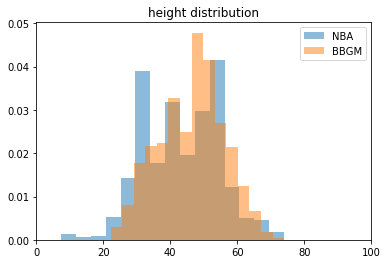

In [115]:
#_ = plt.hist(Xn[:,list(X.columns).index('FTp36')],150,density=True,alpha=0.5,label='NBA')
#_ = plt.hist(X['FTp36'],150,alpha=0.5,density=True,label='BBGM')
#plt.legend()
#plt.figure()
_ = plt.hist(player_heights,15,density=True,alpha=0.5,label='NBA')
_ = plt.hist(ratings[:,0],15,alpha=0.5,density=True,label='BBGM')
plt.title('height distribution')
plt.legend()
plt.xlim(0,100)

In [116]:
X.mean(0)-Xn.mean(0)

FTr       24.899617
MP        -1.911940
FGp36     -0.956906
FGAp36    -2.362036
FTp36     -1.311966
FTAp36    -1.949147
TRBp36    -1.772534
ASTp36    -0.086179
PFp36     -2.371299
PTSp36    -1.931879
dtype: float64

In [117]:
#for n,v in zip(X.columns,Xn.max(0)):
#    print(n,v)

In [118]:
rosters = {}

for team in all_tables[tyear[0]]:
    for name in all_tables[tyear[0]][team]['roster'].index:
        name = name.replace('\xa0\xa0',' ')
        nsplit = name.split(' ')
        if nsplit[-1] in ['Jr.','Sr.','I','II','III',"IV",'(TW)','Jr','Sr']:
            name = ' '.join(nsplit[:-1])
        rosters[name] = team
    #print(team,)
#print(rosters)

In [119]:
new_team = [
        ('CHO','CHA'),
        ('NOP','NOH'),
        ('BRK','NJN'),
        ('OKC','SEA'),
        ('NOK','NOH'),
        ('NOH','CHH'),
        ('MEM','VAN'),
        ('WAS','WSB'),
        ('SAC','KCK'),
        ('LAC','SDC'),
        ('UTA','NOJ'),
        ('SDC','BUF'),
        ('NJN','NYN'),
        ('GSW','SFW'),
        ('SAS','DLC'),
        ('DLC','TEX'),
        ('HOU','SDR'),
        ('CHA','CHH'),
        ('SAA','TEX'),
        ('SAS','SAA'),
        ('DEN','DNA'),
        ('DNA','DNR'),
        ('WSB','CAP'),
        ('CAP','BAL'),
        ('BAL','CHZ'),
        ('CHZ','CHP'),
        ('SEA','SDS'),
        ('SDS','SDA'),
        ('MIA','FLO'),
        ('FLO','MMF'),
        ('MMF','MNM'),
        ('SFW','PHW'),
        ('LAL','MNL'),
        ('UTA','UTS'),
        ('UTS','LAS'),
        ('LAS','ANA'),
        ('CHH','SSL'),
        ('SSL','CAR'),
        ('CAR','HSM'),
        ('DET','FTW'),
        ('MLH','TRI'),
        ('ATL','STL'),
        ('STL','MLH'),
        ('MLH','TRI'),
        ('PHI','SYR'),
        ('CIN','ROC'),
        ('TOR','PTC'),
        ('PTC','PTP'),
        ('MNP','PTP'),
        ('PTP','MNP'),
        ('VAN','MMS'),
        ('MMS','MMT'),
        ('MMT','MMP'),
        ('MMP','NOB'),
        ('ORL','VIR'),
        ('VIR','WSA'),
        ('WSA','OAK'),
        ('SAC','KCK'),
        ('KCK','KCO'),
        ('KCO','KCK'),
        ('KCK','CIN'),
        ('CIN','ROC'),]
st = set()
for t in new_team:
    st.add(t[0])
    st.add(t[1])

In [120]:
#playersOG

NameError: name 'playersOG' is not defined

In [185]:
import random
def load_roster(filename):
    base = json.load(open(filename,'rb'))

    
    for i in range(len(base['players'])):
        player = base['players'][i]
        if 'name' in player and player['name'] !='':
            sname = base['players'][i]['name'].split()
            base['players'][i]['firstName'] = sname[0]
            base['players'][i]['lastName'] = ' '.join(sname[1:])
            del base['players'][i]['name']
    players = base['players']
    base['version'] = 32

    return players,base
playersOG,base = load_roster('normed.json')
abbrev_to_tid = {_['abbrev']:_['tid'] for _ in base['teams']}
abbrev_to_tid['PHO'] = abbrev_to_tid['PHX']
abbrev_to_tid['CHO'] = abbrev_to_tid['CHA']
abbrev_to_tid['BRK'] = abbrev_to_tid['BKN']
abbrev_to_tid['NOH'] = abbrev_to_tid['NOP']
abbrev_to_tid['NJN'] = abbrev_to_tid['BKN']
abbrev_to_tid['SEA'] = abbrev_to_tid['OKC']
abbrev_to_tid['KCK'] = abbrev_to_tid['SAC']
abbrev_to_tid['SDC'] = abbrev_to_tid['LAC']
abbrev_to_tid['WSB'] = abbrev_to_tid['WAS']
abbrev_to_tid['CHH'] = abbrev_to_tid['CHA']
abbrev_to_tid['VAN'] = abbrev_to_tid['MEM']
abbrev_to_tid['NOK'] = abbrev_to_tid['NOP']
abbrev_to_tid['NOK'] = abbrev_to_tid['NOP']
abbrev_to_tid['BUF'] = abbrev_to_tid['LAC']
abbrev_to_tid['CAP'] = abbrev_to_tid['WAS']

if GEN_YEAR < 2000:
    for nt,ot in new_team:
        try:
            abbrev_to_tid[ot] = abbrev_to_tid[nt]
        except:
            print(nt,ot)

base['startingSeason'] = tyear[0]
valid_tids = {abbrev_to_tid[_] for _ in teams}

valid_teams = []
for t in base['teams']:
    if t['tid'] in valid_tids:
        tid = len(valid_teams)
        otid = t['tid']
        t['tid'] = tid
        for k,v in abbrev_to_tid.items():
            if v == otid:
                abbrev_to_tid[k] = tid
        valid_teams.append(t)

if GEN_YEAR < 2010:
    for t in valid_teams:
        for t2 in teams:
            if abbrev_to_tid[t2] == t['tid']:
                print(t['abbrev'],t2,abbrev_to_tid[t2])
                t['abbrev'] = t2
                nsplit = all_tables[GEN_YEAR][t2]['name'].split(' ')
                t['region'] = ' '.join(nsplit[:-1])
                t['name'] = nsplit[-1]
                t['imgURL'] = all_tables[GEN_YEAR][t2]['logo']
                
cid_count = {0:0,1:0}
for t in valid_teams:
    cid_count[t['cid']]+=1
while abs(cid_count[0]-cid_count[1]) > 1:
    idx = list(range(len(valid_teams)))
    random.shuffle(idx)
    if cid_count[0] > cid_count[1]:
        for i in idx:
            if valid_teams[i]['cid'] == 0:
                valid_teams[i]['cid'] = 1
                break
    else:
        for i in idx:
            if valid_teams[i]['cid'] == 1:
                valid_teams[i]['cid'] = 0
                break
    cid_count = {0:0,1:0}
    for t in valid_teams:
        cid_count[t['cid']]+=1
    
#print(valid_teams)
base['teams'] = valid_teams


if tyear[0] < CURRENT_YEAR-2:
    del base['draftPicks']

players_discard = [_ for _ in playersOG if  _['tid'] > -3 ]
players_FA = [_ for _ in playersOG if  _['tid'] == -1 ]

if GEN_YEAR < 1970:
    for team in base['teams']:
        team['did'] = team['cid']
    CONFS = []
    CONFS.append({'did':0, 'cid':0, 'name':'East'})
    CONFS.append({'did':1, 'cid':1, 'name':'West'})
    base['gameAttributes'].append({'key':'divs', 'value': CONFS})
#-2 is for undrafted players the ongoing or upcoming draft
#-4 is for prospects in next year's draft
#-5 is for prospects in the draft after that.
players = []
if GEN_YEAR == CURRENT_YEAR:
    players_to_keep = []
    for p in playersOG:
        if not 'name' in p:
            p['name'] = p['firstName'] + ' ' + p['lastName']
        pname = p['name']
        psplit = pname.split(' ')
        if psplit[-1] in ['Jr','Sr','Jr.',"Sr.",'III',"II"]:
            pname = ' '.join(psplit[:-1])
        if p['tid'] in [-2,-4,-5]:
            players.append(p)
        elif p['tid'] in [-1]:
            if pname in player_stats[GEN_YEAR]:
                continue
            else:
                players.append(p)
    #players += [_ for _ in playersOG if _['tid'] in [-1,-2,-4,-5]]
elif GEN_YEAR == CURRENT_YEAR-1:
    for player in playersOG:
        if player['tid'] == -2:
            player['tid'] = -4
            players.append(player)
        elif player['tid'] == -4:
            player['tid'] = -5
            players.append(player)
elif tyear[0] == CURRENT_YEAR-2:
    for player in playersOG:
        if player['tid'] == -2:
            player['tid'] = -5
            players.append(player)

y_keys = [_.lower() for _ in y.columns]

y_map = { 'hgt': 'hgt',
   'stre': 'str',
   'spd': 'spd',
   'jmp': 'jmp',
   'endu': 'end',
   'ins': 'ins',
   'dnk': 'dnk',
   'ft': 'ft.1',
   'fg': '2pt',
   'tp': '3pt',
   'diq': 'diq',
   'oiq': 'oiq',
   'drb': 'drb',
   'pss': 'pss',
   'reb': 'reb' }

SAA TEX
MLH TRI
CIN ROC
MNP PTP
ATL STL 0
BOS BOS 1
CHA HSM 2
CHI CHI 3
DEN DNR 4
DET DET 5
GSW SFW 6
HOU SDR 7
LAL LAL 8
MEM NOB 9
MIA MNM 10
NYK NYK 11
OKC SEA 12
ORL OAK 13
PHI PHI 14
SAC CIN 15
SAS DLC 16
TOR PTP 17
UTA ANA 18
WAS BAL 19


In [186]:
if False:
    ri = 0
    _ = plt.hist(yt[:,ri],100,normed=True,alpha=0.5,label='predicted')
    _ = plt.hist(y.iloc[:,ri],100,normed=True,alpha=0.5,label='labels')
    _ = plt.hist(ratings[:,ri],100,normed=True,alpha=0.5,label='dataset')
    plt.xlim(-100,100)
    plt.legend()
elif False:
    plt.figure(figsize=(7*3,6*3))

    for ri in range(len(X.columns)):
        #ri = 13
        #plt.figure()
        plt.subplot(6,7,ri+1)

        _ = plt.hist(Xn[:,ri],100,density=True,alpha=0.5,label='NBA')
        _ = plt.hist(X.iloc[:,ri],100,density=True,alpha=0.5,label='BBGM')
        plt.legend()
        plt.title(X.columns[ri])# + ' ' + str(ri))
        plt.tight_layout()
        #plt.xlim(-100,100)
from collections import OrderedDict

def write_roman(num):

    roman = OrderedDict()
    roman[1000] = "M"
    roman[900] = "CM"
    roman[500] = "D"
    roman[400] = "CD"
    roman[100] = "C"
    roman[90] = "XC"
    roman[50] = "L"
    roman[40] = "XL"
    roman[10] = "X"
    roman[9] = "IX"
    roman[5] = "V"
    roman[4] = "IV"
    roman[1] = "I"

    def roman_num(num):
        for r in roman.keys():
            x, y = divmod(num, r)
            yield roman[r] * x
            num -= (r * x)
            if num <= 0:
                break

    return "".join([a for a in roman_num(num)])

In [187]:
if gen_FA > 0:
    player_names_f = player_names + ["Free Agent{}".format(write_roman(i)) for i in range(gen_FA)]
    player_years_f = player_years + [GEN_YEAR for i in range(gen_FA)]
    # scale them down, we don't want a bunch of amazing replacements
    MEAN_S = 0.95
    STD_S = 0.25
    rp_ratings = np.random.multivariate_normal(MEAN_S*replacement_player_mean_r,STD_S*replacement_player_cov_r,size=(gen_FA))
    ratings_f = np.vstack([ratings,rp_ratings])
else:
    player_names_f = player_names
    player_years_f = player_years
    ratings_f = ratings

In [188]:
#player_stats[py]['Bill Allen'][table_columns(['roster'].index()]
#table_columns[(py,'ANA')]['roster']

In [189]:
import pprint
import copy

pp = pprint.PrettyPrinter()
for i,name in enumerate(player_names_f):
    py = player_years_f[i]
    name = player_names_f[i]
    sname = name.split(' ')
    new_player = {}
    new_player['firstName'] = sname[0]
    new_player['lastName'] = ' '.join(sname[1:])
    year_gap = 0
    if name in player_stats[py] and 'roster' in player_stats[py][name]:
        team = player_stats[py][name]['team']
        
        exp_years =  player_stats[py][name]['roster'][0][-2]
        exp_years = int(0 if exp_years == 'R' else exp_years)

        year_gap = (py-GEN_YEAR) #0,1,2

        if 'Sprewell' in name:
            print(py==GEN_YEAR,name in rosters,year_gap,exp_years)
        if py == GEN_YEAR and name in rosters:
            tid = abbrev_to_tid[rosters[name]]
        elif exp_years != 0:
            continue
        elif py < GEN_YEAR:
            continue
        else:
            tid = [-2,-4,-5][year_gap-1]
        try:
            new_player['tid'] = tid
            new_player['pos'] = player_stats[py][name]['roster'][0][table_columns[(py,team)]['roster'].index('Pos')].replace('-','')
            new_player['weight'] = int(float(player_stats[py][name]['roster'][0][table_columns[(py,team)]['roster'].index('Wt')]))
            ht = [int(_) for _ in player_stats[py][name]['roster'][0][table_columns[(py,team)]['roster'].index('Ht')].split('-')]
            new_player['hgt'] = ht[0]*12 + ht[1]
            new_player['draft'] = {'year':py-exp_years-1,"round": 0, "pick": 0, "tid": -1, "originalTid": -1,}
        except:
            print(name)
            print('aaaa')
            raise
        try:
            br = int(player_stats[py][name]['roster'][0][table_columns[(py,team)]['roster'].index('Birth Date')].split(',')[-1])
        except:
            br = py-30
        new_player['born'] = {'year':br,'loc':''}
        if tyear[0]>=CURRENT_YEAR and 'contracts' in player_stats[py][name]:
            #print(name,player_stats[py][name]['contracts'])
            ctrct = [float(_) for _ in player_stats[py][name]['contracts'][0] if _.replace('\xa0','0.5') != '0.5']
            if len(ctrct) > 0:
                new_player['contract'] = {'amount':int(round(sum(ctrct)/(1000*len(ctrct)))),'exp':CURRENT_YEAR-1+len(ctrct)}
    elif name in player_stats[py]:
        #print(name)
        if py == GEN_YEAR:
            tid = -1
        else:
            continue
        if py-1 in player_stats and name in player_stats[py-1]:
            year_gap = (py-GEN_YEAR) #0,1,2

            exp_years =  player_stats[py-1][name]['roster'][0][-2]
            exp_years = int(0 if exp_years == 'R' else exp_years)
            new_player['weight'] = int(float(player_stats[py-1][name]['roster'][0][table_columns[(py-1,team)]['roster'].index('Wt')]))
            ht = [int(_) for _ in player_stats[py-1][name]['roster'][0][1].split('-')]
            new_player['pos'] = player_stats[py-1][name]['roster'][0][0].replace('-','')
            new_player['hgt'] = ht[0]*12 + ht[1]
            new_player['born'] = {'year':int(player_stats[py-1][name]['roster'][0][3].split(',')[-1]),'loc':''}
            new_player['draft'] = {'year':py-exp_years-1,"round": 0, "pick": 0, "tid": -1, "originalTid": -1}
        else:     
            new_player['pos'] = 'GF'
            new_player['weight'] = 200
            new_player['hgt'] = 6*12 + 8
            new_player['born'] = {'year':GEN_YEAR-28,'loc':''}
        new_player['tid'] = tid
    elif i > Xn.shape[0]:
        #print(name)
        new_player['tid'] = int(-1)
        new_player['weight'] = int(np.random.normal(220,20))
        new_player['hgt'] = int(np.random.normal(6*12+6,3))
        new_player['born'] = {'year':int(GEN_YEAR-np.random.normal(32,2)),'loc':''}
        new_player['pos'] = "GF"
        #print(new_player)
    else:
        print(name)
        continue#print('aasdsd')
        #raise
    #if name == 'Ben Simmons':
    #    print(new_player)
    #print(year_gap,py,name)

    try:
        scale_rookie = [1.0,1.0,1.0,1.0][year_gap]
        sub_rookie = [0,-2,-4,-6][year_gap]
        r_vec = {k: scale_rookie*ratings_f[i,y_keys.index(km)]+sub_rookie for k,km in y_map.items()}
        #print(y_map.keys())
        r_vec['endu'] -= 4.5*min(1,year_gap)
        r_vec['diq'] -= 4*min(1,year_gap)
        r_vec['oiq'] -= 4*min(1,year_gap)
        r_vec = {k: int(np.clip(v,0,100)) for k,v in r_vec.items()}

        new_player['ratings'] = [r_vec]
        #new_player['ratings']
        players.append(new_player)
    except:
        print(name)
        print('bbbb')
        pass
    if 'Sprewell' in name:
        print(new_player,players[-1]['lastName'],len(players))
    #if name in ['Luka Doncic']: #"Trevon Duval",'LeBron James'
        #print(py,exp_years)
    #    pp.pprint(new_player)
        #pp.pprint(player_vectors[player_names.index(name)])

Free Agent


In [190]:
#table_columns[(1968,'ANA')]['roster'].index('Exp')
#table_columns[(py,team)]['roster'],player_stats[1968]['Bill Allen']['roster'][0]


In [191]:
base['players'] = players
with open('auto_roster_{}.json'.format(tyear[0]),'wt') as fp:
    json.dump(base,fp, sort_keys=True)

In [192]:
len(ratings),len(ratings_f),len(ratings)+gen_FA
players

[{'firstName': 'Bill',
  'lastName': 'Allen',
  'tid': 18,
  'pos': 'C',
  'weight': 205,
  'hgt': 80,
  'draft': {'year': 1967, 'round': 0, 'pick': 0, 'tid': -1, 'originalTid': -1},
  'born': {'year': 1938, 'loc': ''},
  'ratings': [{'hgt': 56,
    'stre': 47,
    'spd': 45,
    'jmp': 44,
    'endu': 37,
    'ins': 35,
    'dnk': 46,
    'ft': 37,
    'fg': 39,
    'tp': 40,
    'diq': 48,
    'oiq': 42,
    'drb': 46,
    'pss': 42,
    'reb': 55}]},
 {'firstName': 'Bob',
  'lastName': 'Bedell',
  'tid': 18,
  'pos': 'PF',
  'weight': 205,
  'hgt': 79,
  'draft': {'year': 1967, 'round': 0, 'pick': 0, 'tid': -1, 'originalTid': -1},
  'born': {'year': 1944, 'loc': ''},
  'ratings': [{'hgt': 54,
    'stre': 54,
    'spd': 40,
    'jmp': 37,
    'endu': 44,
    'ins': 53,
    'dnk': 54,
    'ft': 57,
    'fg': 58,
    'tp': 58,
    'diq': 53,
    'oiq': 47,
    'drb': 50,
    'pss': 46,
    'reb': 57}]},
 {'firstName': 'Larry',
  'lastName': 'Bunce',
  'tid': 18,
  'pos': 'C',
  'weight